# Data Preparation

## Load data from sqlite3 in json

In [1]:
from utils.db.get_data_db import get_data_json
## accuracy
from utils.information_retrieval import get_times_per_tt, get_confidence_per_tt, get_answers_scores_multiple_sel, get_answers_scores_single_sel

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_02.db'
data = get_data_json(db_file_path)

## Data cleaning

Remove any incomplete registration created when participants by mistake clicked multiple times the "Registration" button.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end" or data[p]['status'] == "end_thanks":
        data_processed[p] = data[p]

## Get observed Response Times, Accuracy, and Confidence per Task Type (TT) and group (IG, SG, AG)

<!-- There are 3 research questions in the study. -->

TT1: Given an intervention, which is the correct causal model?

TT2: Given a set of causal models and intervention, which interventions are sufficient to identify the causal model? Which is the correct causal model? 

----------------------

IG: Interaction Group

SG: Static Group

AG: Animation Group

<!-- The study consisted of 3 problems. Each problem was modelled by a different probabilistic model. There were 3 sets of questions in each problem with every set corresponding to one of the research questions. -->

<!-- The task ids per problem and RQ are following:

**Problem 1: Temperature in Scotland**

RQ1: t1

RQ2: t2, t3, t4

RQ3: t5

**Problem 2: Random real-number generator**

RQ1: t6

RQ2: t7, t8, t9

RQ3: t10, t11

**Problem 3: Lorry drivers reaction times**

RQ1: t12, t13

RQ2: t14, t15, t16, t17

RQ3: t18, t19 -->

In [3]:
# task ids per TT
t_ids = {}
t_ids['T1'] = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
t_ids['T2'] = ['t11','t12','t13','t14','t15','t16']

## times
times_i, times_s, times_a = get_times_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>
## confidence
conf_i, conf_s, conf_a = get_confidence_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>

## TT1
## corr answ taken responses as multiple choice selections
answ_sc_i_multi, answ_sc_s_multi, answ_sc_a_multi = get_answers_scores_multiple_sel(data_processed, 
                                                                                                 t_ids['T1'], 
                                                                                                 db_file_path, 'T1') # returns Dict<t_id:List>
## corr answ taken responses as single selection
answ_sc_i_singl, answ_sc_s_singl, answ_sc_a_singl = get_answers_scores_single_sel(data_processed, 
                                                                                               t_ids['T1'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
## TT2
answ_sc_i_model_T2, answ_sc_s_model_T2, answ_sc_a_model_T2 = get_answers_scores_single_sel(data_processed, 
                                                                                               t_ids['T2'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
answ_sc_i_interv_T2, answ_sc_s_interv_T2, answ_sc_a_interv_T2 = get_answers_scores_multiple_sel(data_processed, 
                                                                                                 t_ids['T2'], 
                                                                                                 db_file_path, 'T2') # returns Dict<t_id:List>

In [12]:
from collections import Counter
times = {}
for p in data_processed:
    if data_processed[p]['mode'] == 'i':
        for t in data_processed[p]['t_answers']:
            if t not in times:
                times[t] = []
            times[t].append(data_processed[p]['t_answers'][t]['options'])
            # if len(data_processed[p]['t_answers'][t]['options'])>1 and t in t_ids['T2']:                
                # print([(t,p,k) for (k,v) in Counter(data_processed[p]['t_answers'][t]['options']).items() if v > 1])
                # print(t,p,data_processed[p]['t_answers'][t]['options'])
            times[t].append(data_processed[p]['t_answers'][t]['model_opt'])
            #print(t,data_processed[p]['t_answers'][t]['response_time'])
## times['t10'] vs answ_sc_i_multi['t10']
times['t11']

[['Atomic intervention on tiredness'],
 'Causal Model 3',
 ['Atomic intervention on insomnia',
  'Atomic intervention on anxiety',
  'Atomic intervention on tiredness'],
 'Causal Model 2',
 ['Atomic intervention on insomnia'],
 'Causal Model 2',
 ['Atomic intervention on anxiety'],
 'Causal Model 2',
 ['Atomic intervention on tiredness'],
 'Causal Model 2',
 ['Atomic intervention on tiredness'],
 'Causal Model 3',
 ['Atomic intervention on insomnia'],
 'Causal Model 1',
 ['Atomic intervention on tiredness'],
 'Causal Model 3',
 ['Atomic intervention on tiredness'],
 'Causal Model 2',
 ['Atomic intervention on insomnia'],
 'Causal Model 2',
 ['Atomic intervention on insomnia', 'Atomic intervention on anxiety'],
 'Causal Model 2']

In [13]:
answ_sc_i_interv_T2['t11']

[1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 2]

In [29]:
## T1
data = {'accuracy': [], 'time': [],'conf': [], 'condition': [], 'task':[], 'participant':[]}
participants_i = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 'i' ]
participants_s = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 's']
participants_a = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 'a']
## INTERACTION
answers = answ_sc_i_singl
times = times_i['T1']
confidence = conf_i['T1']
mode = 'i'
participants = participants_i
for t in answers:
    data['accuracy'].extend(answers[t])
    data['time'].extend(times[t])
    data['conf'].extend(confidence[t])
    data['condition'].extend([mode]*len(answers[t]))
    data['task'].extend([t]*len(answers[t]))
    data['participant'].extend(participants)
## ANIMATION
answers = answ_sc_a_singl
times = times_a['T1']
confidence = conf_a['T1']
mode = 'a'
participants = participants_a
for t in answers:
    data['accuracy'].extend(answers[t])
    data['time'].extend(times[t])
    data['conf'].extend(confidence[t])
    data['condition'].extend([mode]*len(answers[t]))
    data['task'].extend([t]*len(answers[t]))
    data['participant'].extend(participants)
## STATIC
answers = answ_sc_s_singl
times = times_s['T1']
confidence = conf_s['T1']
mode = 's'
participants = participants_s
for t in answers:
    data['accuracy'].extend(answers[t])
    data['time'].extend(times[t])
    data['conf'].extend(confidence[t])
    data['condition'].extend([mode]*len(answers[t]))
    data['task'].extend([t]*len(answers[t]))
    data['participant'].extend(participants)
df = pd.DataFrame.from_dict(data)

In [30]:
data_perf_per_part = {'participant_id':[], 'num_tasks_correct':[], 'condition':[]}
for p in df['participant'].unique():
    data_perf_per_part['num_tasks_correct'].append(df[df['participant'] == p]['accuracy'].sum())
    data_perf_per_part['participant_id'].append(str(p))
    if p in participants_i:
        data_perf_per_part['condition'].append('i')
    elif p in participants_a:
        data_perf_per_part['condition'].append('a')
    elif p in participants_s:
        data_perf_per_part['condition'].append('s')
df_perf_part = pd.DataFrame.from_dict(data_perf_per_part)

In [31]:
## T2 - MODELs
data = {'accuracy': [], 'time': [],'conf': [], 'condition': [], 'task':[], 'participant':[]}
participants_i = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 'i' ]
participants_s = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 's']
participants_a = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 'a']

## INTERACTION
answers = answ_sc_i_model_T2
times = times_i['T2']
confidence = conf_i['T2']
mode = 'i'
participants = participants_i
for t in answers:
    data['accuracy'].extend(answers[t])
    data['time'].extend(times[t])
    data['conf'].extend(confidence[t])
    data['condition'].extend([mode]*len(answers[t]))
    data['task'].extend([t]*len(answers[t]))
    data['participant'].extend(participants)
## ANIMATION
answers = answ_sc_a_model_T2
times = times_a['T2']
confidence = conf_a['T2']
mode = 'a'
participants = participants_a
for t in answers:
    data['accuracy'].extend(answers[t])
    data['time'].extend(times[t])
    data['conf'].extend(confidence[t])
    data['condition'].extend([mode]*len(answers[t]))
    data['task'].extend([t]*len(answers[t]))
    data['participant'].extend(participants)
## STATIC
answers = answ_sc_s_model_T2
times = times_s['T2']
confidence = conf_s['T2']
mode = 's'
participants = participants_s
for t in answers:
    data['accuracy'].extend(answers[t])
    data['time'].extend(times[t])
    data['conf'].extend(confidence[t])
    data['condition'].extend([mode]*len(answers[t]))
    data['task'].extend([t]*len(answers[t]))
    data['participant'].extend(participants)
df_T2_model = pd.DataFrame.from_dict(data)

<AxesSubplot: xlabel='participant_id', ylabel='num_tasks_correct'>

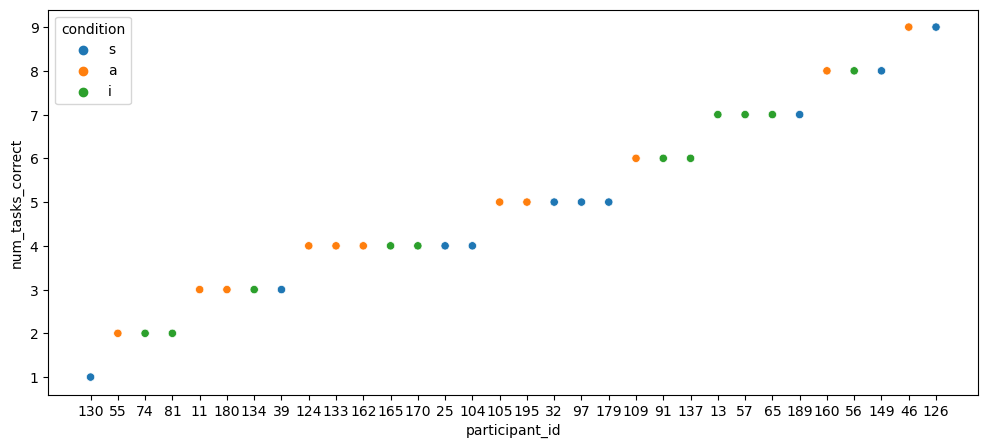

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.scatterplot(df_perf_part.sort_values(['num_tasks_correct','condition']), x='participant_id', y='num_tasks_correct', hue = 'condition', ax = ax)

<AxesSubplot: xlabel='Proportion', ylabel='num_tasks_correct'>

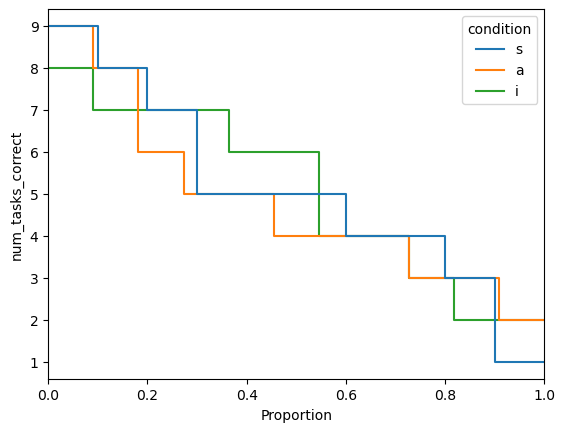

In [36]:
sns.ecdfplot(df_perf_part.sort_values(['num_tasks_correct','condition']), y='num_tasks_correct',  hue = 'condition',complementary=True)

<AxesSubplot: xlabel='num_tasks_correct', ylabel='condition'>

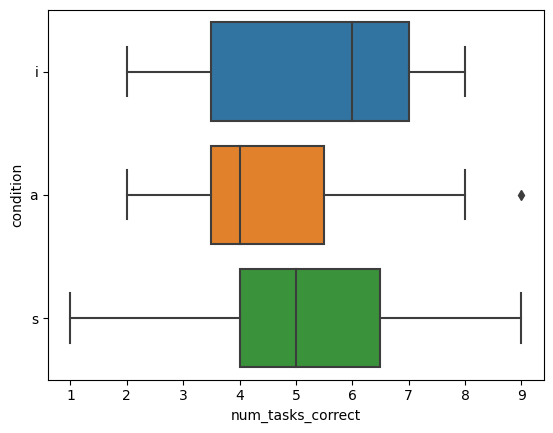

In [110]:
sns.boxplot(data=df_perf_part, x="num_tasks_correct", y="condition")

<AxesSubplot: xlabel='conf', ylabel='condition'>

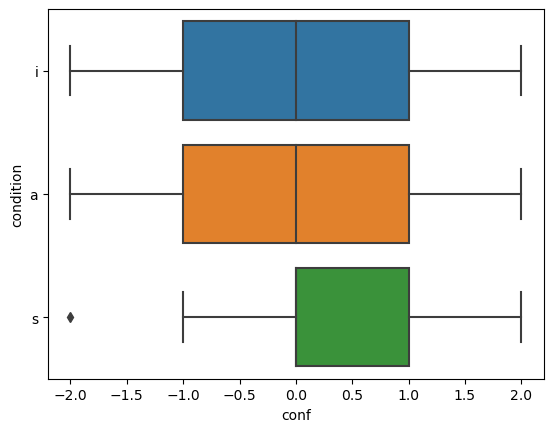

In [114]:
sns.boxplot(data=df, x="conf", y="condition")

<AxesSubplot: xlabel='num_tasks_correct'>

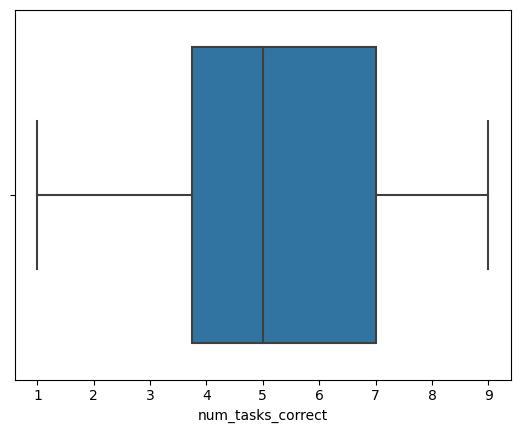

In [111]:
sns.boxplot(data=df_perf_part, x="num_tasks_correct")

<AxesSubplot: xlabel='task', ylabel='Count'>

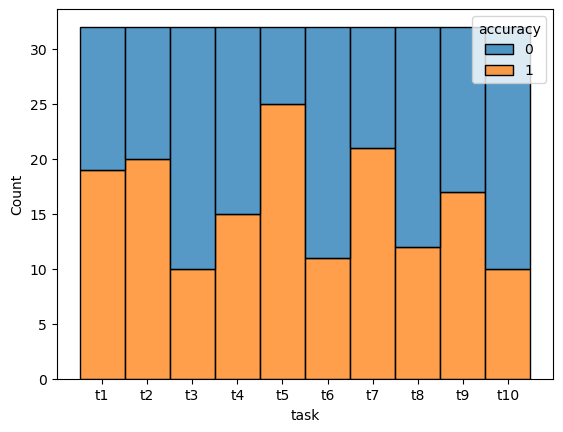

In [39]:
## T1
# ## all
# sns.countplot(df, x="accuracy", hue='task')
sns.histplot(df, x="task", hue='accuracy', multiple="stack")
## animation
# sns.countplot(df[df['condition'] == 'a'], x="accuracy", hue='task')
# sns.histplot(df[df['condition'] == 'a'], x="task", hue='accuracy', multiple="stack")

<AxesSubplot: xlabel='task', ylabel='Count'>

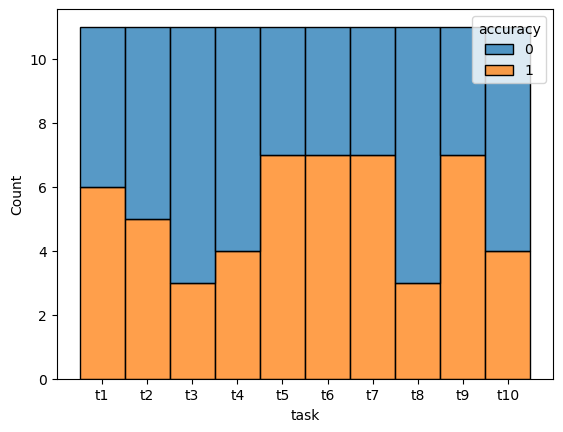

In [40]:
sns.histplot(df[df['condition'] == 'a'], x="task", hue='accuracy', multiple="stack")

<AxesSubplot: xlabel='task', ylabel='Count'>

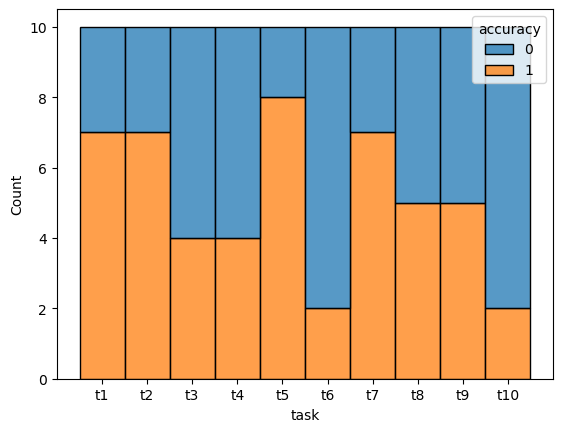

In [37]:
sns.histplot(df[df['condition'] == 's'], x="task", hue='accuracy', multiple="stack")

<AxesSubplot: xlabel='task', ylabel='Count'>

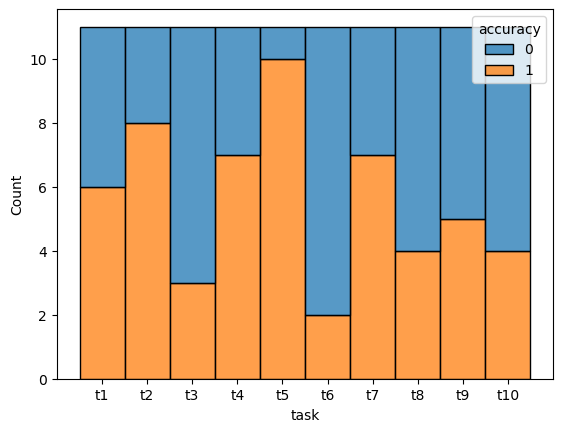

In [38]:
sns.histplot(df[df['condition'] == 'i'], x="task", hue='accuracy', multiple="stack")

<AxesSubplot: xlabel='task', ylabel='Count'>

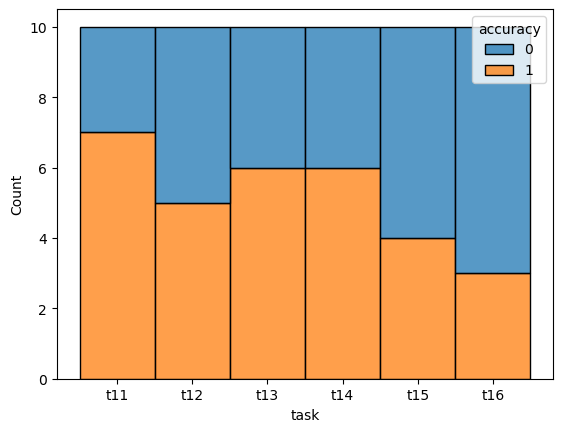

In [27]:
## T2
# sns.histplot(df_T2_model, x="task", hue='accuracy', multiple="stack")
sns.histplot(df_T2_model[df_T2_model['condition'] == 's'], x="task", hue='accuracy', multiple="stack")

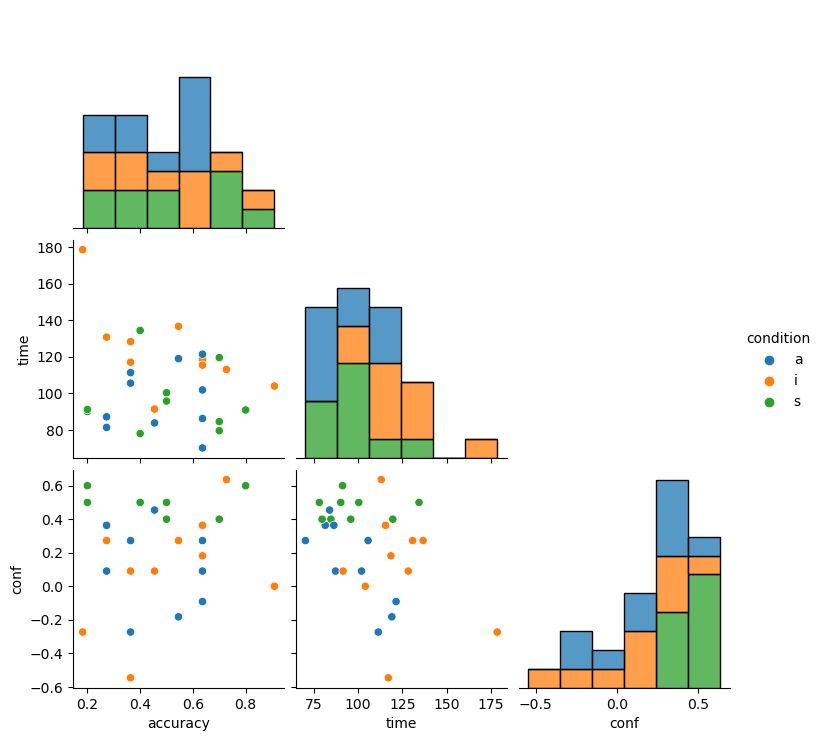

In [42]:
# sns.jointplot(data=df, x="accuracy", y="conf", kind="hist")
## all
# sns.pairplot(df, corner=True, diag_kind='hist',kind = 'hist')
# ## animated
# sns.pairplot(df[df['condition'] == 'a'], corner=True, diag_kind='hist',kind = 'hist',plot_kws={'color':'green'},diag_kws={'color':'green'})
# ## interactive
# sns.pairplot(df[df['condition'] == 'i'], corner=True, diag_kind='hist',kind = 'hist',plot_kws={'color':'orange'},diag_kws={'color':'orange'})
# ## static
# sns.pairplot(df[df['condition'] == 's'], corner=True, diag_kind='hist',kind = 'hist',plot_kws={'color':'red'},diag_kws={'color':'red'})
sns.pairplot(df.groupby(['task', 'condition'], as_index=False)['accuracy','time','conf'].mean(), corner=True, diag_kind='hist',kind = 'scatter', hue = 'condition',diag_kws={'multiple':'stack'})


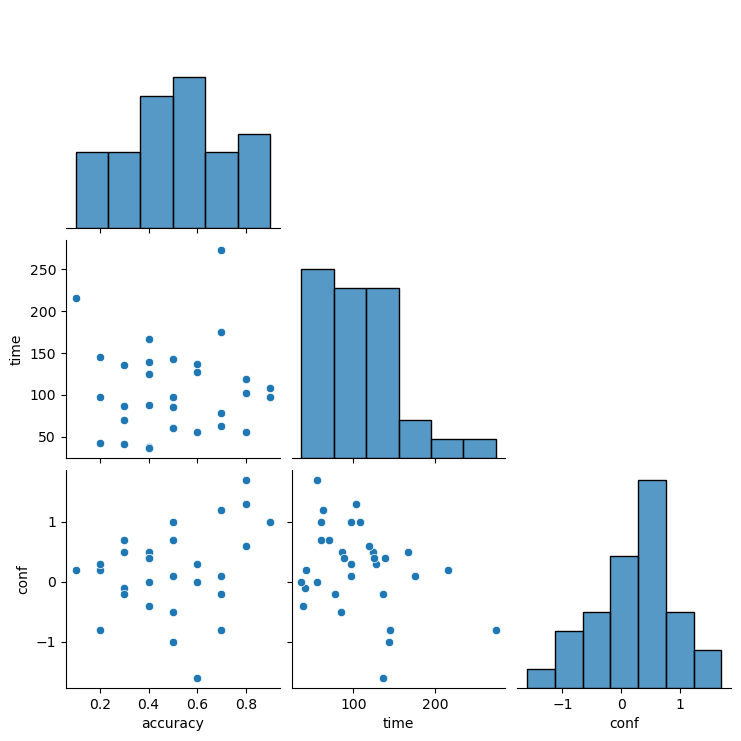

In [49]:
sns.pairplot(df.groupby(['participant'], as_index=False)['accuracy','time','conf'].mean(), vars=['accuracy','time','conf'],corner=True, diag_kind='hist',kind = 'scatter')
# df.groupby(['participant'], as_index=False)['accuracy','time','conf'].mean()